In [1]:
import pickle
import gzip
import numpy as np
import os

import matplotlib.pyplot as plt
import cv2
import cv2 as cv
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter
# import canny edge detector
from skimage.feature import canny

2022-12-19 16:06:05.633974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 16:06:06.695098: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ts/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-19 16:06:06.695218: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-19 16:06:15.083793: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: l

In [2]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [3]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

## Load Data

In [6]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

### Data Augmentation

In [22]:
# train_sample_id = 33
# labeled_frame_idx = 1
# crop = False
# seed = 1

# video = np.copy(train_data[train_sample_id]['video'])
# labels = train_data[train_sample_id]['label']
# box = train_data[train_sample_id]['box']
# labeled_frames = train_data[train_sample_id]['frames']

# # data_gen_args = dict(featurewise_center=True,
# #                      featurewise_std_normalization=True,

# datagen = ImageDataGenerator(horizontal_flip=True,
#                     rotation_range=10,
#                     shear_range=10,
#                     zoom_range=[0.8, 1.1],
#                     height_shift_range=0.1,
#                     width_shift_range=0.1,
#                     brightness_range=(0.3, 1))


In [34]:
def augment_data(image, mask):
    seed = 1
    data_gen_args = dict(horizontal_flip=True,
                         rotation_range=10,
                         shear_range=10,
                         zoom_range=[0.8, 1.1],
                         height_shift_range=0.1,
                         width_shift_range=0.1,
                         brightness_range=(0.3, 1))

    frame_augmentor = ImageDataGenerator(**data_gen_args)
    label_augmentor = ImageDataGenerator(**data_gen_args)

    myimg = image.reshape((1,) + image.shape + (1,))
    mask = mask.reshape((1,) + mask.shape + (1,))

    aug_frames = frame_augmentor.flow(myimg, seed=seed, batch_size=1)
    aug_labels = label_augmentor.flow(mask, seed=seed, batch_size=1)

    plt.imshow(aug_frames[0][0].reshape(image.shape), cmap='gray')
    plt.show()
    plt.imshow(aug_labels[0][0].reshape(mask.shape), cmap='gray')
    plt.show()

    return aug_frames, aug_labels

Image preparation

In [51]:
x_train = []
y_train = []
x_test = []
for d in train_data:
    for i in d["frames"]:
        x_train.append(cv2.resize(d["video"][:,:,i], dsize=(256, 256)))
        y_train.append(cv2.resize(255 * d["label"][:,:,i].astype(np.ubyte), dsize=(256, 256)))

for d in test_data:
    for i in range(d["video"].shape[2]):
        x_test.append(cv2.resize(d["video"][:,:,i], dsize=(256, 256)))

x_train = np.expand_dims(np.array(x_train, dtype=np.single), 3)
y_train = np.expand_dims(np.array(y_train, dtype=np.single), 3)
x_test = np.expand_dims(np.array(x_test, dtype=np.single), 3)

In [52]:
print(len(x_train))
print(x_train[0].shape)

195
(256, 256, 1)


Median Filter Smoothed

In [53]:
x_train_median_filtered = []
x_test_median_filtered = []
for i in range(x_train.shape[0]):
    x_train_median_filtered.append(median_filter(x_train[i,:,:,0], size=3))
for i in range(x_test.shape[0]):
    x_test_median_filtered.append(median_filter(x_test[i,:,:,0], size=3))
# for i in range(len(x_train)):
#     x_train_median_filtered.append(median_filter(x_train[i], size=3))
# for i in range(len(x_test)):
#     x_test_median_filtered.append(median_filter(x_test[i], size=3))

Canny Edges Extracted

In [54]:
x_train_canny_edges = []
x_test_canny_edges = []
for i in range(x_train.shape[0]):
    x_train_canny_edges.append(canny(x_train[i,:,:,0], sigma=3))

for i in range(x_test.shape[0]):
    x_test_canny_edges.append(canny(x_test[i,:,:,0], sigma=3))
# for i in range(len(x_train)):
#     x_train_canny_edges.append(canny(x_train[i], sigma=3))

# for i in range(len(x_test)):
#     x_test_canny_edges.append(canny(x_test[i], sigma=3))

Preview of image channels

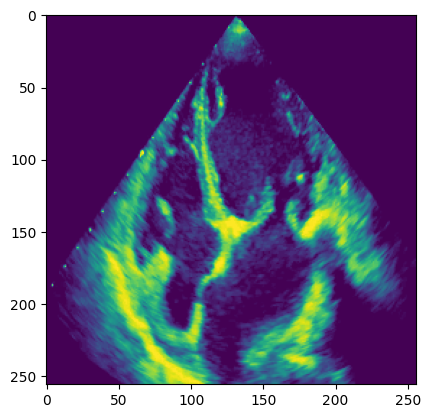

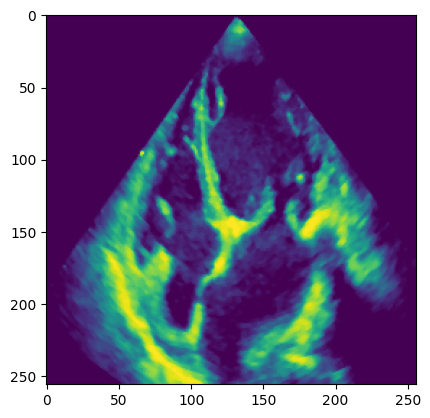

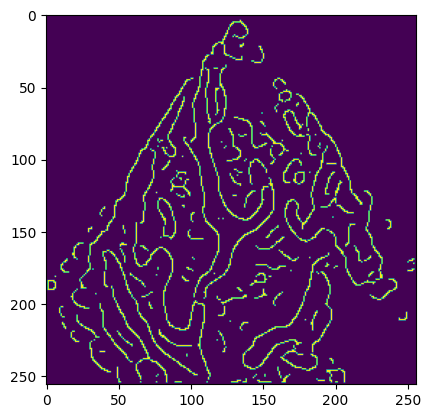

In [10]:
# plt.imshow(x_train[0,:,:,0])
# plt.show()
# plt.imshow(x_train_median_filtered[0])
# plt.show()
# plt.imshow(x_train_canny_edges[0])
# plt.show()
plt.imshow(x_test[0,:,:,0])
plt.show()
plt.imshow(x_test_median_filtered[0])
plt.show()
plt.imshow(x_test_canny_edges[0])
plt.show()

In [47]:
print(len(x_train))
print(x_train[0].shape)
print(len(x_train_median_filtered))
print(x_train_median_filtered[0].shape)
print(len(x_train_canny_edges))
print(x_train_canny_edges[0].shape)


195
(256, 256)
195
(256, 256)
195
(256, 256)


In [49]:
# Concatenate the images
x_train = np.concatenate((x_train, np.array(x_train_median_filtered, dtype=np.single)), axis=2)
x_train = np.concatenate((x_train, np.array(x_train_canny_edges, dtype=np.single)), axis=2)

x_test = np.concatenate((x_test, np.array(x_test_median_filtered, dtype=np.single)), axis=2)
x_test = np.concatenate((x_test, np.array(x_test_canny_edges, dtype=np.single)), axis=2)


In [50]:
x_test.shape

(1507, 256, 768)

In [55]:
# Concatenate the images
x_train = np.concatenate((x_train, np.expand_dims(np.array(x_train_median_filtered, dtype=np.single), 3)), axis=3)
x_train = np.concatenate((x_train, np.expand_dims(np.array(x_train_canny_edges, dtype=np.single), 3)), axis=3)

x_test = np.concatenate((x_test, np.expand_dims(np.array(x_test_median_filtered, dtype=np.single), 3)), axis=3)
x_test = np.concatenate((x_test, np.expand_dims(np.array(x_test_canny_edges, dtype=np.single), 3)), axis=3)


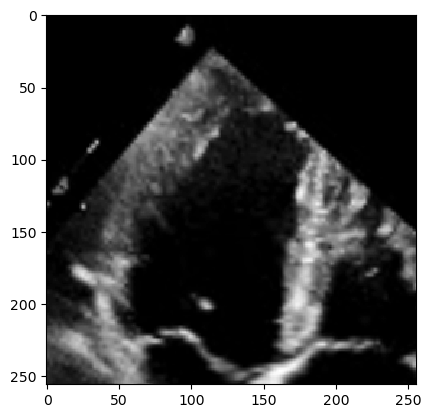

TypeError: Invalid shape (1, 256, 256, 1) for image data

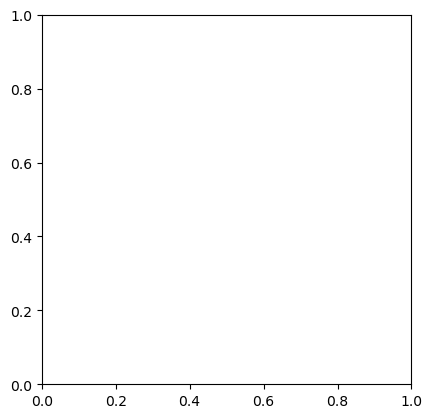

In [35]:
aug_frames, aug_labels = augment_data(x_train[0,:,:,0], y_train[0,:,:,0])

In [ ]:


## Deformation (doesn't work yet)

N_AUG_PER_SAMPLE = 20
x_train = []
y_train = []
for d in train_data:
    for i in d["frames"]:
        image = d["video"][:, :, i]
        mask = 255 * d["label"][:, :, i].astype(np.ubyte)
        aug_images, aug_masks = augment_data(image, mask)
        for tt in range(N_AUG_PER_SAMPLE):
            x_train.append(cv2.resize(next(aug_images)[0], dsize=(360, 360)))
            y_train.append(cv2.resize(next(aug_masks)[0], dsize=(360, 360)))

In [21]:
print("train shape: ", x_train.shape)
print("test shape: ", x_test.shape)
# A lot more because for training we only consider segmented frames

train shape:  (195, 256, 256, 3)
test shape:  (1507, 256, 256, 3)
flowed length:  10
flowed shape:  (256, 256, 3)


example of visualizing augmented data

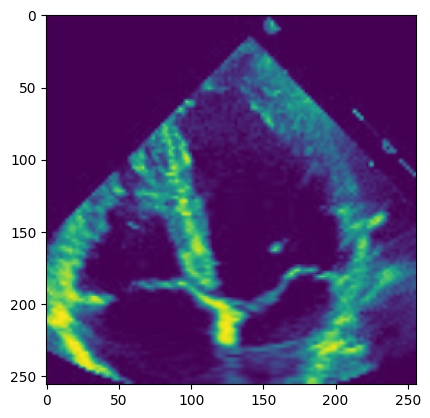

x:  (10, 256, 256, 3)
y:  (10, 256, 256, 1)


In [13]:
plt.imshow(x_train[0,:,:,0])
plt.show()
augmented_image = datagen.flow(x_train, y=y_train, batch_size=10, seed=seed, shuffle=False)
print("x: ",augmented_image[0][0].shape)
print("y: ", augmented_image[0][1].shape)
# for i in range(10):
#     plt.imshow(augmented_image[0][0][i,:,:,0])
#     plt.show()

Manual Train / Validation Split (80/20 = 52/13) making sure that only expert data is in validation set

In [14]:
x_val = x_train[52:,:,:,:]
x_train = x_train[:52,:,:,:]
y_val = y_train[52:]
y_train = y_train[:52]

## Model

In [15]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding="same")(x)#kernel_initializer = "he_normal"
   x = layers.BatchNormalization()(x)
   x = layers.ReLU()(x)
   x = layers.Conv2D(n_filters, 3, padding="same")(x)#kernel_initializer = "he_normal"
   x = layers.BatchNormalization()(x)
   x = layers.ReLU()(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   #p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 2, 2, padding="valid")(x)
   x = layers.concatenate([x, conv_features])
   #x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [16]:
def get_model(img_size):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    
    f1, p1 = downsample_block(inputs, 16)
    f2, p2 = downsample_block(p1, 32)
    f3, p3 = downsample_block(p2, 64)
    #f4, p4 = downsample_block(p3, 256)
    
    #bottleneck = double_conv_block(p4, 512)
    bottleneck = double_conv_block(p3, 128)
    
    #u6 = upsample_block(bottleneck, f4, 256)
    u7 = upsample_block(bottleneck, f3, 64)
    u8 = upsample_block(u7, f2, 32)
    u9 = upsample_block(u8, f1, 16)

    outputs = layers.Conv2D(1, 1, padding="valid", activation = "sigmoid")(u9)
    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

## Training

In [17]:
# fix seed
seed = 1
np.random.seed(seed)

In [18]:


EPOCHS = [8,8,8,8,8]
BATCH_SIZES = [4,4,4,4,4]
NR_OF_AUGMENTATIONS = [0,5,10,15,20]
LEARNING_RATES = [1e-3,1e-3,1e-3,1e-3,1e-3]
LOSS_FUNCTIONS = [keras.losses.BinaryCrossentropy(),keras.losses.BinaryCrossentropy(),keras.losses.BinaryCrossentropy(),keras.losses.BinaryCrossentropy(),keras.losses.BinaryCrossentropy()]
print('------------------------------------------------------------------------------------')
print(f'Training for fold {0  + 1} ...')
print(f'BATCH_SIZE: {BATCH_SIZES[0]}')
print(f'EPOCHS: {EPOCHS[0]}')
print(f'nr_of_augmentations: {NR_OF_AUGMENTATIONS[0]}')
print(f'learning_rate: {LEARNING_RATES[0]}')
print(f'loss_function: {LOSS_FUNCTIONS[0]}')
print('------------------------------------------------------------------------------------')

keras.backend.clear_session()
model = get_model(256)
model.summary()
print(model.output_shape)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATES[0]),
    #loss=keras.losses.CategoricalCrossentropy(),
    loss=LOSS_FUNCTIONS[0],
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')]
)
# Fit the model with augmented data
model.fit(datagen.flow(x_train, y=y_train, batch_size=NR_OF_AUGMENTATIONS[0], seed=seed, shuffle=False),
        validation_data=(x_val, y_val),
        batch_size=BATCH_SIZES[0],
        epochs=EPOCHS[0],
        verbose=2
    )

    #scores = model.evaluate(samples[test_idx], labels[test_idx], verbose=0)
    #f1 = f1_score(np.argmax(labels[test_idx], axis=1), np.argmax(model.predict(samples[test_idx]), axis=1), average='micro')
    #print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; f1_score of {f1}')
    # break



------------------------------------------------------------------------------------
Training for fold 1 ...
BATCH_SIZE: 4
EPOCHS: 8
nr_of_augmentations: 15
learning_rate: 0.001
loss_function: <keras.losses.BinaryCrossentropy object at 0x7ff53d18eac0>
------------------------------------------------------------------------------------


2022-12-17 12:58:10.929900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [74]:


EPOCHS = [8,8,8,8,8]
BATCH_SIZES = [4,4,4,4,4]
NR_OF_AUGMENTATIONS = [0,5,10,15,20]
LEARNING_RATES = [1e-3,1e-3,1e-3,1e-3,1e-3]
LOSS_FUNCTIONS = [keras.losses.BinaryCrossentropy(),keras.losses.BinaryCrossentropy(),keras.losses.BinaryCrossentropy(),keras.losses.BinaryCrossentropy(),keras.losses.BinaryCrossentropy()]
for fold_nr in range(5):
    print('------------------------------------------------------------------------------------')
    print(f'Training for fold {fold_nr  + 1} ...')
    print(f'BATCH_SIZE: {BATCH_SIZES[fold_nr]}')
    print(f'EPOCHS: {EPOCHS[fold_nr]}')
    print(f'nr_of_augmentations: {NR_OF_AUGMENTATIONS[fold_nr]}')
    print(f'learning_rate: {LEARNING_RATES[fold_nr]}')
    print(f'loss_function: {LOSS_FUNCTIONS[fold_nr]}')
    print('------------------------------------------------------------------------------------')

    keras.backend.clear_session()
    model = get_model(256)
    model.summary()
    print(model.output_shape)

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATES[fold_nr]),
      #loss=keras.losses.CategoricalCrossentropy(),
      loss=LOSS_FUNCTIONS[0],
      metrics=[keras.metrics.BinaryAccuracy(name='accuracy')]
    )
# Fit the model with augmented data
    model.fit(datagen.flow(x_train, y=y_train, batch_size=NR_OF_AUGMENTATIONS[fold_nr], seed=seed, shuffle=False),
            validation_data=(x_val, y_val),
            batch_size=BATCH_SIZES[fold_nr],
            epochs=EPOCHS[fold_nr],
            verbose=2
        )

    #scores = model.evaluate(samples[test_idx], labels[test_idx], verbose=0)
    #f1 = f1_score(np.argmax(labels[test_idx], axis=1), np.argmax(model.predict(samples[test_idx]), axis=1), average='micro')
    #print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; f1_score of {f1}')
    # break



------------------------------------------------------------------------------------
Training for fold 1 ...
BATCH_SIZE: 4
EPOCHS: 8
nr_of_augmentations: 10
learning_rate: 0.001
loss_function: <keras.losses.BinaryCrossentropy object at 0x7f9f1b78f6a0>
------------------------------------------------------------------------------------
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                     

In [19]:
# Save the model
model.save('three_channel_segmentation_model_15_augm.h5')

In [61]:
# Load model
model = tf.keras.models.load_model('three_channel_segmentation_model.h5')

In [20]:
predictions = model.predict(x_test)

48/48 [==============================] - 42s 876ms/step


In [21]:
train_predictions = model.predict(x_train)

2/2 [==============================] - 2s 683ms/step


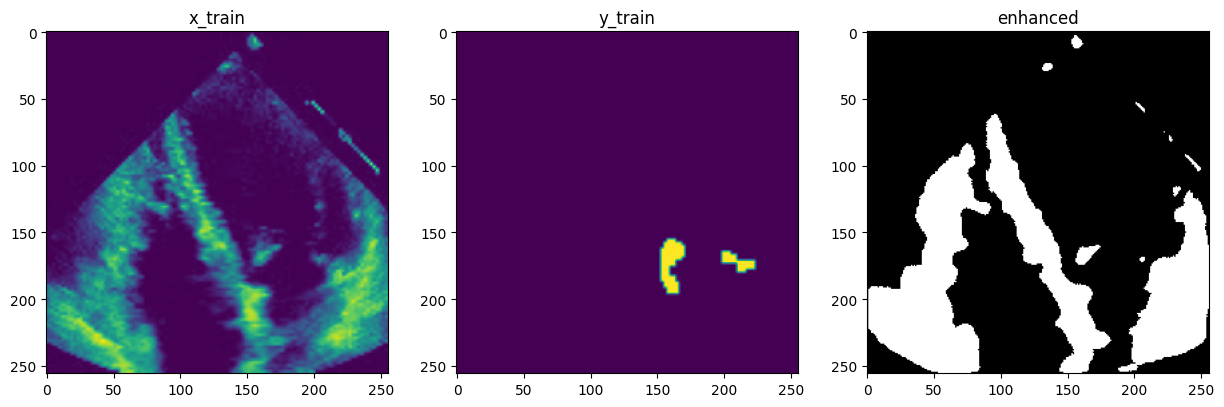

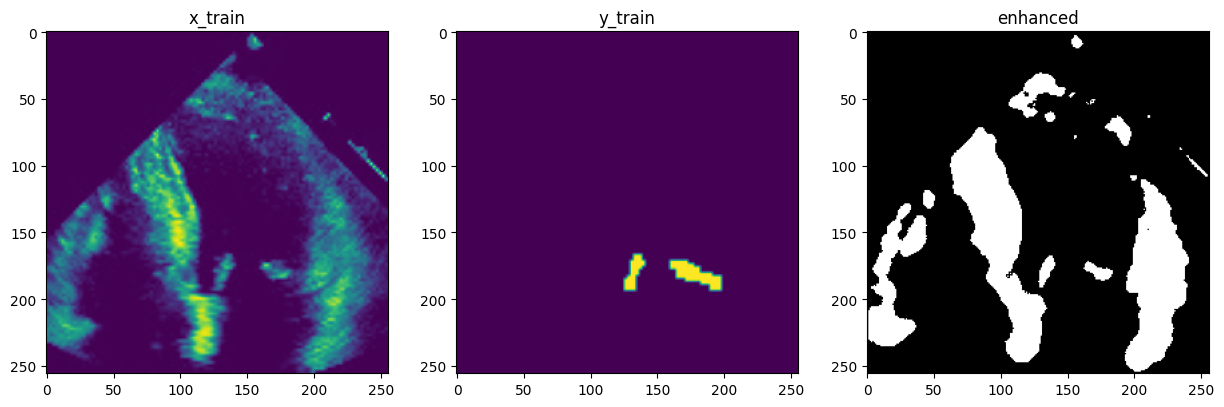

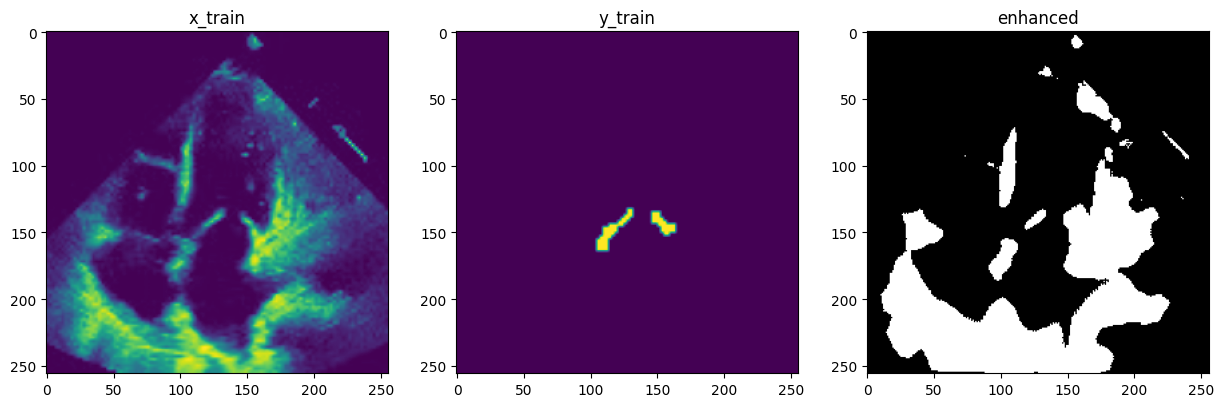

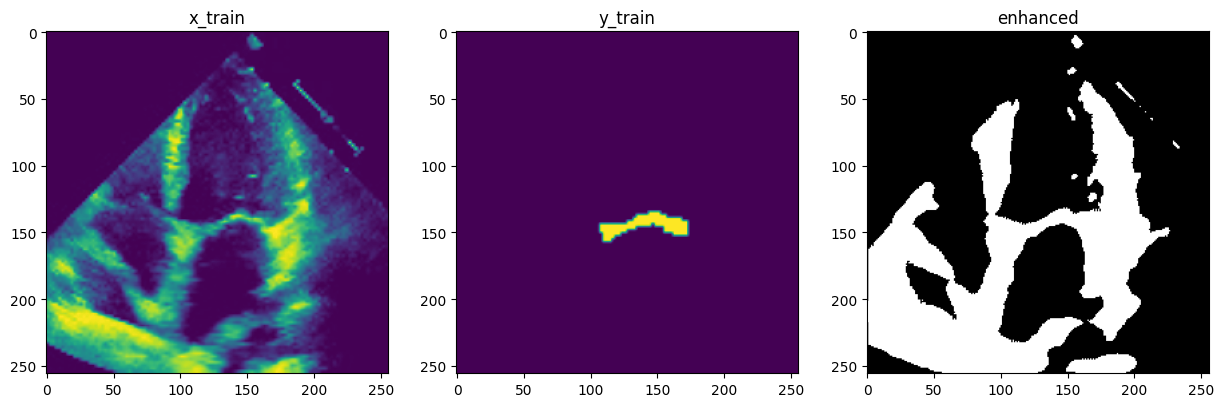

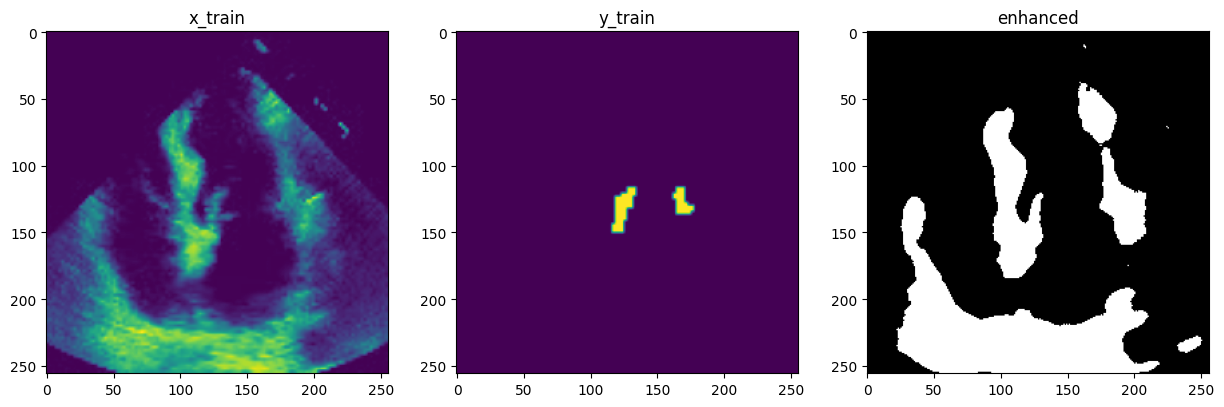

In [22]:
for i in range(5):
    random_index = np.random.randint(0, len(x_train))
    enhanced = 255 * train_predictions[random_index,:,:,0]
    enhanced = enhanced > 255 * 0.99
    # Create a horizontal subplot of xtrain image, ytrain image and enhanced image
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(x_train[random_index,:,:,0])
    axs[0].set_title('x_train')
    axs[1].imshow(y_train[random_index,:,:,0])
    axs[1].set_title('y_train')
    axs[2].imshow(enhanced, cmap='gray')
    axs[2].set_title('enhanced')
    plt.show()

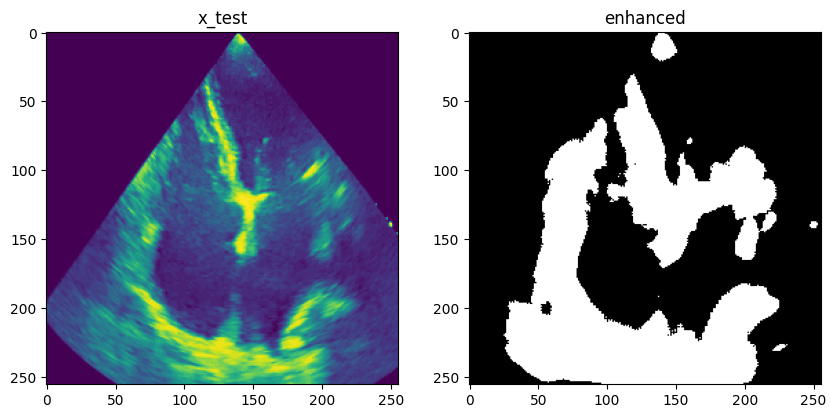

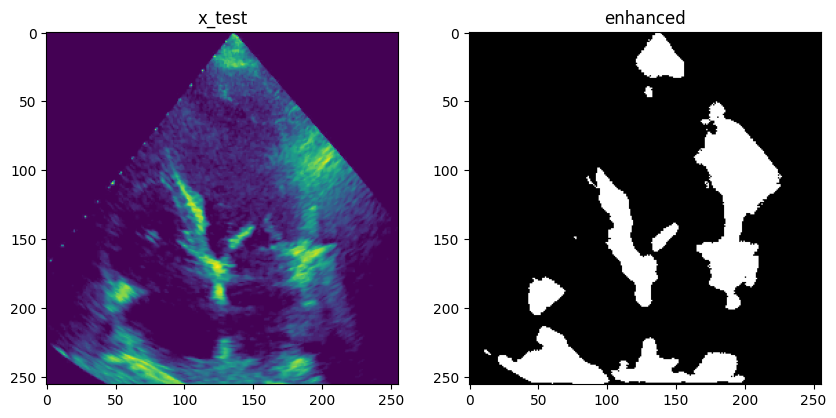

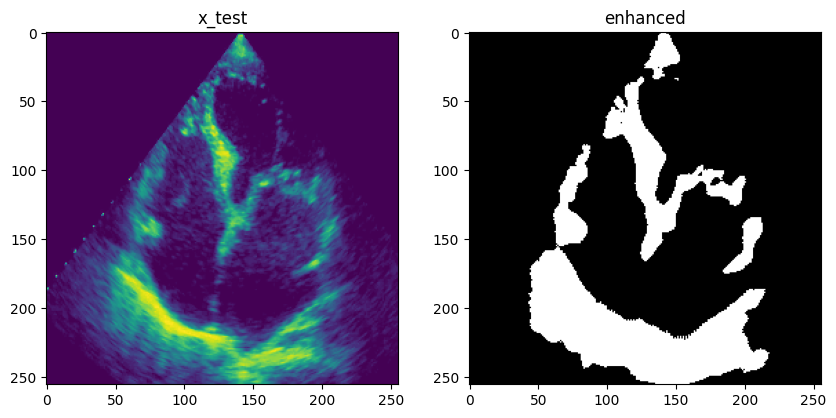

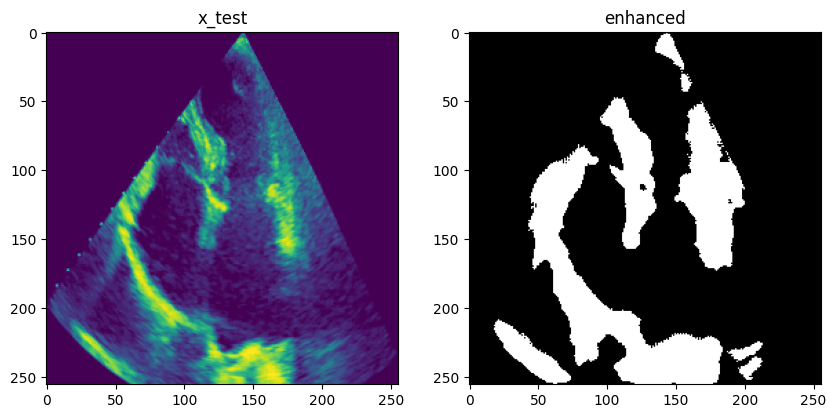

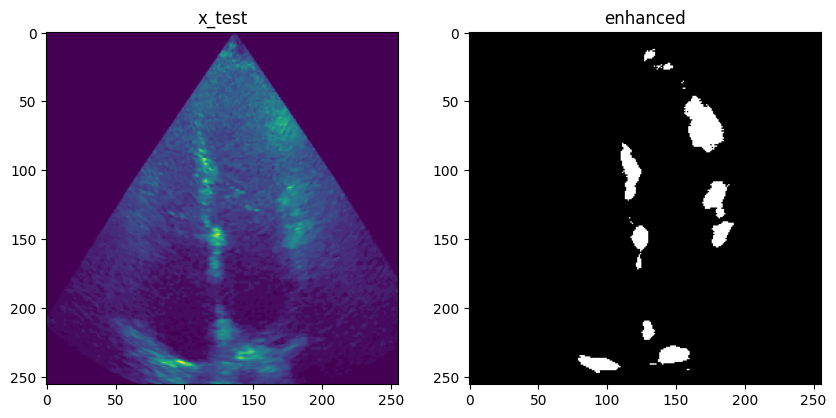

In [23]:
for i in range(5):
    random_index = np.random.randint(0, len(x_test))
    enhanced = 255 * predictions[random_index,:,:,0]
    enhanced = enhanced > 255 * 0.99
    # Create a horizontal subplot of the two images x_test and enhanced
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].imshow(x_test[random_index,:,:,0])
    axs[0].set_title('x_test')
    axs[1].imshow(enhanced, cmap='gray')
    axs[1].set_title('enhanced')


Evaluation (To DO)

In [ ]:
# pred = model.predict(x_train[test_idx])
# pred = np.squeeze(pred)

# TH = 0.999
# NB_OF_AREAS = 4
# intersection = 0
# union = 0
# fehlt = 0
# for i in range(39):
#     idx = test_idx[i]
#     ff = train_data[idx//3]["frames"][idx%3]
#     gt = train_data[idx//3]["label"][:,:,ff]
#     gt_img = im.fromarray(gt)

#     pp = cv2.resize(255 * pred[i,:,:], dsize=gt.shape[::-1])
#     pp = pp > (255 * TH)    
#     pred_img = im.fromarray(pp)

#     lab = label(pp)
#     rps = regionprops(lab)
#     area_idx = np.argsort([r.area for r in rps])[::-1]
#     new_pp = np.zeros_like(pp)
#     for j in area_idx[:NB_OF_AREAS]:
#         new_pp[tuple(rps[j].coords.T)] = True
#     new_pred_img = im.fromarray(new_pp)

#     fehlt += np.count_nonzero(np.logical_and(gt, np.logical_not(new_pp)))
#     intersection += np.count_nonzero(np.logical_and(gt, new_pp))
#     union += np.count_nonzero(np.logical_or(gt, new_pp))

# print(fehlt)
# print("score:")
# print(intersection / union)

## Save predictions in correct format

In [40]:
# make prediction for test
predictions = []
for d in test_data:
    prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
    height = prediction.shape[0]
    width = prediction.shape[1]
    prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True
    
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

/tmp/ipykernel_20373/701677749.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
